
# Part 1 — Q‑Learning & Policy Iteration on FrozenLake

This notebook implements:
- Tabular **Q‑Learning** for `FrozenLake-v1`
- **Hyperparameter sweeps** for α (learning rate), γ (discount), and ε (exploration)
- **Policy Iteration** baseline using the environment transition model
- **Comparison** and plots


In [1]:

import numpy as np, random
from collections import defaultdict
import matplotlib.pyplot as plt

try:
    import gymnasium as gym
    IS_GYMNASIUM=True
except Exception:
    import gym
    IS_GYMNASIUM=False

def make_env(slippery=True, render_mode=None):
    if IS_GYMNASIUM:
        return gym.make("FrozenLake-v1", is_slippery=slippery, render_mode=render_mode)
    else:
        return gym.make("FrozenLake-v1", is_slippery=slippery)


In [2]:

def epsilon_greedy(Q, s, nA, eps, rng):
    if rng.random() < eps:
        return rng.randrange(nA)
    return int(np.argmax(Q[s]))


In [3]:

def evaluate_greedy(env, Q, episodes=1000, seed=7):
    rng = random.Random(seed)
    nA = env.action_space.n
    total = 0.0
    for _ in range(episodes):
        if IS_GYMNASIUM:
            s, _ = env.reset(seed=rng.randint(0, 10**9))
        else:
            s = env.reset(seed=rng.randint(0, 10**9))
        done = False
        while not done:
            a = int(np.argmax(Q[s])) if s in Q else rng.randrange(nA)
            if IS_GYMNASIUM:
                s, r, term, trunc, _ = env.step(a)
                done = term or trunc
            else:
                s, r, done, _ = env.step(a)
            total += r
    return total / episodes


In [4]:

def q_learning(env, alpha=0.5, gamma=0.99, eps_start=1.0, eps_end=0.1, eps_decay=0.9995,
               episodes=25000, eval_every=1000, seed=0):
    rng = random.Random(seed)
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    rewards = []
    eval_returns = []
    eps = eps_start

    for ep in range(episodes):
        if IS_GYMNASIUM:
            s, _ = env.reset(seed=rng.randint(0, 10**9))
        else:
            s = env.reset(seed=rng.randint(0, 10**9))
        done = False
        G = 0.0
        while not done:
            a = epsilon_greedy(Q, s, nA, eps, rng)
            if IS_GYMNASIUM:
                s2, r, terminated, truncated, _ = env.step(a)
                done = terminated or truncated
            else:
                s2, r, done, _ = env.step(a)
            best_next = np.max(Q[s2])
            td_target = r + gamma * best_next * (0.0 if done else 1.0)
            Q[s][a] += alpha * (td_target - Q[s][a])
            s = s2
            G += r

        rewards.append(G)
        eps = max(eps_end, eps * eps_decay)

        if (ep + 1) % eval_every == 0:
            eval_returns.append(evaluate_greedy(env, Q, episodes=500))

    return Q, np.array(rewards), np.array(eval_returns)


In [5]:

def sweep_alpha(env, alphas=(0.1, 0.5, 0.9), episodes=20000):
    results = {}
    for a in alphas:
        Q, _, _ = q_learning(env, alpha=a, gamma=0.99, eps_start=1.0, eps_end=0.1,
                             eps_decay=0.9995, episodes=episodes, eval_every=2000, seed=42)
        results[a] = evaluate_greedy(env, Q, episodes=1500, seed=123)
    return results

def sweep_gamma(env, gammas=(0.80, 0.95, 0.999), episodes=20000):
    results = {}
    for g in gammas:
        Q, _, _ = q_learning(env, alpha=0.5, gamma=g, eps_start=1.0, eps_end=0.1,
                             eps_decay=0.9995, episodes=episodes, eval_every=2000, seed=43)
        results[g] = evaluate_greedy(env, Q, episodes=1500, seed=124)
    return results

def sweep_epsilon(env, eps_triplets=((1.0, 0.1, 0.999), (1.0, 0.01, 0.9995), (0.5, 0.1, 0.9999)), episodes=20000):
    results = {}
    for (es, ee, ed) in eps_triplets:
        key = f"start={es},end={ee},decay={ed}"
        Q, _, _ = q_learning(env, alpha=0.5, gamma=0.99, eps_start=es, eps_end=ee,
                             eps_decay=ed, episodes=episodes, eval_every=2000, seed=44)
        results[key] = evaluate_greedy(env, Q, episodes=1500, seed=125)
    return results


In [6]:

def policy_evaluation(P, nS, nA, policy, gamma=0.99, tol=1e-8):
    V = np.zeros(nS)
    while True:
        delta = 0.0
        for s in range(nS):
            v = 0.0
            for a, pa in enumerate(policy[s]):
                for prob, s2, r, done in P[s][a]:
                    v += pa * prob * (r + gamma * (0 if done else V[s2]))
            delta = max(delta, abs(v - V[s]))
            V[s] = v
        if delta < tol:
            break
    return V

def policy_improvement(P, nS, nA, V, gamma=0.99):
    policy = np.zeros((nS, nA))
    for s in range(nS):
        q = np.zeros(nA)
        for a in range(nA):
            for prob, s2, r, done in P[s][a]:
                q[a] += prob * (r + gamma * (0 if done else V[s2]))
        best_a = int(np.argmax(q))
        row = np.zeros(nA); row[best_a] = 1.0
        policy[s] = row
    return policy

def policy_iteration(env, gamma=0.99, tol=1e-8, max_iter=1000):
    P = env.unwrapped.P
    nS = env.observation_space.n
    nA = env.action_space.n
    policy = np.ones((nS, nA)) / nA
    for _ in range(max_iter):
        V = policy_evaluation(P, nS, nA, policy, gamma, tol)
        new_policy = policy_improvement(P, nS, nA, V, gamma)
        if np.allclose(new_policy, policy):
            break
        policy = new_policy
    return policy, V

def evaluate_policy(env, policy, episodes=3000, seed=101):
    rng = random.Random(seed)
    wins = 0
    for _ in range(episodes):
        if IS_GYMNASIUM:
            s, _ = env.reset(seed=rng.randint(0,10**9))
        else:
            s = env.reset(seed=rng.randint(0,10**9))
        done = False
        while not done:
            a = int(np.argmax(policy[s]))
            if IS_GYMNASIUM:
                s, r, term, trunc, _ = env.step(a); done = term or trunc
            else:
                s, r, done, _ = env.step(a)
            wins += r
    return wins/episodes


In [7]:

# === Run training & evaluations ===
env = make_env(slippery=True)

Q, train_rewards, eval_success = q_learning(env,
    alpha=0.5, gamma=0.99, eps_start=1.0, eps_end=0.1, eps_decay=0.9995,
    episodes=20000, eval_every=1000, seed=0)

final_success = evaluate_greedy(env, Q, episodes=2000)
print(f"Final greedy success rate: {final_success:.3f}")

policy, V = policy_iteration(env, gamma=0.99)
pi_success = evaluate_policy(env, policy, episodes=3000)
print(f"Policy Iteration success rate: {pi_success:.3f}")


Final greedy success rate: 0.733
Policy Iteration success rate: 0.743


In [8]:

# === Hyperparameter sweeps (quick) ===
alpha_results  = sweep_alpha(env, episodes=15000)
gamma_results  = sweep_gamma(env, episodes=15000)
epsilon_results = sweep_epsilon(env, episodes=15000)

print("Alpha sweep:", alpha_results)
print("Gamma sweep:", gamma_results)
print("Epsilon sweep:", epsilon_results)


Alpha sweep: {0.1: 0.7426666666666667, 0.5: 0.0, 0.9: 0.15733333333333333}
Gamma sweep: {0.8: 0.44866666666666666, 0.95: 0.5106666666666667, 0.999: 0.41333333333333333}
Epsilon sweep: {'start=1.0,end=0.1,decay=0.999': 0.17466666666666666, 'start=1.0,end=0.01,decay=0.9995': 0.7113333333333334, 'start=0.5,end=0.1,decay=0.9999': 0.5173333333333333}


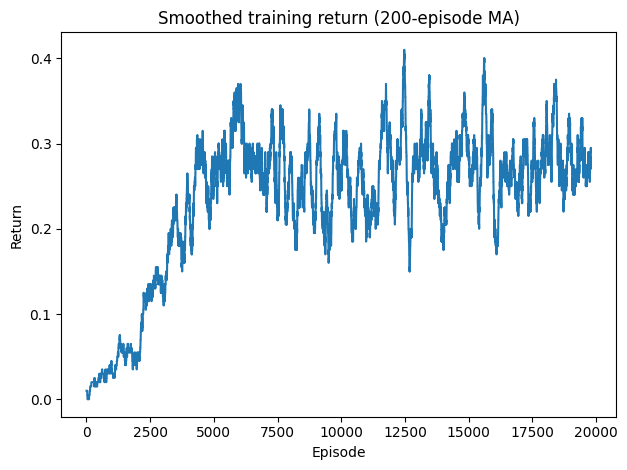

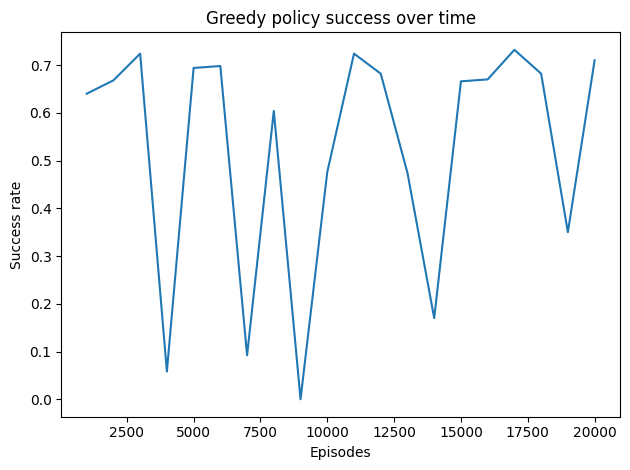

In [9]:

# === Plots ===
import numpy as np, matplotlib.pyplot as plt
if len(train_rewards) >= 200:
    smoothed = np.convolve(train_rewards, np.ones(200)/200, mode='valid')
    plt.figure()
    plt.plot(smoothed)
    plt.title("Smoothed training return (200-episode MA)")
    plt.xlabel("Episode"); plt.ylabel("Return"); plt.tight_layout(); plt.show()

if len(eval_success) > 0:
    xs = np.arange(1, len(eval_success)+1) * 1000
    plt.figure()
    plt.plot(xs, eval_success)
    plt.title("Greedy policy success over time")
    plt.xlabel("Episodes"); plt.ylabel("Success rate"); plt.tight_layout(); plt.show()
